## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [ ]:
install.packages('tsibble')
install.packages('fable')
install.packages('fabletools')
library(tidyverse)
library(tsibble)
library(fable)
library(fabletools)
library(stats)
library(BVAR)
library(reshape2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘quadprog’, ‘progressr’, ‘ggdist’, ‘numDeriv’, ‘fabletools’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'tsibble':
  method        

## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


Series: GDPGR 
Model: AR(2) w/ mean 

Coefficients:
  constant  lag(GS10TB3Mx)     ar1     ar2
    2.0014          0.4212  0.0225  0.0969

sigma^2 estimated as 17.62
AIC = 0.17	AICc = 0.33	BIC = 14.45

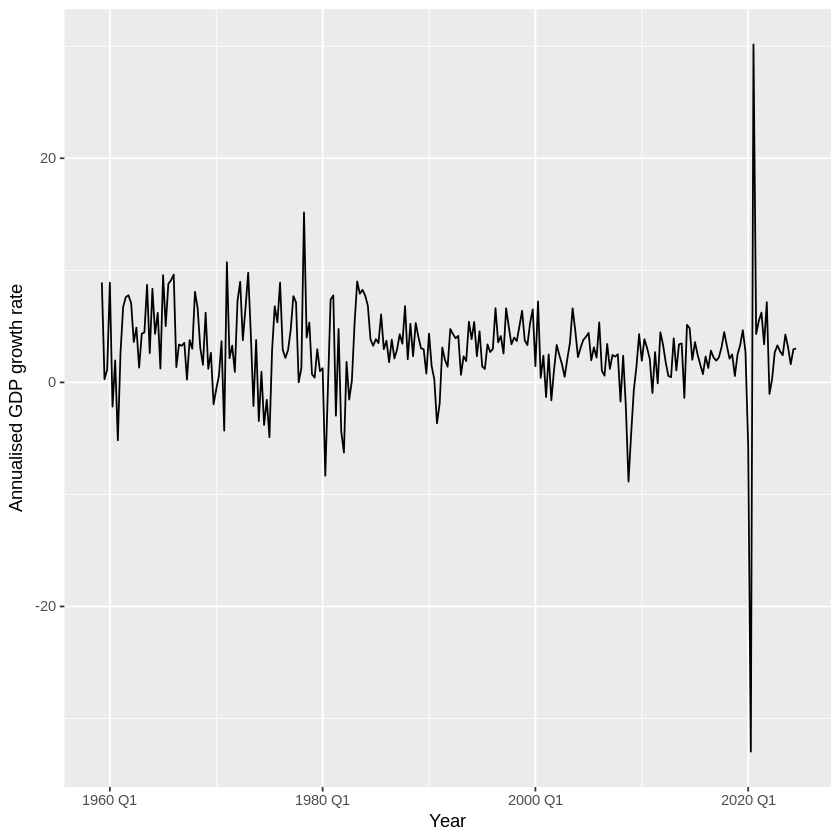

In [ ]:
###...code...###
data = read.csv("https://raw.githubusercontent.com/jack-gin/databustersteam33/refs/heads/main/Quarterly%20Data.csv?token=GHSAT0AAAAAAC6MHN2SDDWIHAUD6VJSAQ7UZ5EW5BA")

data = data[-c(1:38),]
data <- data %>%
  select('sasdate', "GDPC1", 'GS10TB3Mx', 'CLAIMSx', 'ANDENOx', 'UMCSENTx') %>%
  mutate(sasdate = yearquarter(sasdate))
transformed <- fred_transform(data[,-1], type=c('fred_qd'), codes=c(5,1,5,5,2))
transformed <- cbind(data$sasdate[-1], transformed) %>%
  rename(date = 'data$sasdate[-1]') %>%
  mutate(GDPC1 = 4 * GDPC1) %>%
  as_tsibble(index=date)
transformed$covid = rep(0)
transformed$covid[208:211] = 1
transformed$covid = as.factor(transformed$covid)
transformed <- transformed %>%
  mutate(
    GS10TB3Mx_lag1 = lag(GS10TB3Mx, 1),
    CLAIMSx_lag1 = lag(CLAIMSx, 1),
    ANDENOx_lag1 = lag(ANDENOx, 1),
    UMCSENTx_lag1 = lag(UMCSENTx, 1),
    GS10TB3Mx_lag2 = lag(GS10TB3Mx, 2),
    CLAIMSx_lag2 = lag(CLAIMSx, 2),
    ANDENOx_lag2 = lag(ANDENOx, 2),
    UMCSENTx_lag2 = lag(UMCSENTx, 2),
    covid_lag1 = lag(covid, 1),
    covid_lag2 = lag(covid, 2))
transformed <- transformed[-c(1:2),]

ar_lags <- transformed[1:193,] %>%
  model(ar1 = AR(GDPC1 ~ order(1)),
        ar2 = AR(GDPC1 ~ order(2)),
        ar3 = AR(GDPC1 ~ order(3)),
        ar4 = AR(GDPC1 ~ order(4)),
        ar5 = AR(GDPC1 ~ order(5)),
        ar6 = AR(GDPC1 ~ order(6)),
        ar7 = AR(GDPC1 ~ order(7)),
        ar8 = AR(GDPC1 ~ order(8))) # Trained on 1968Q2 to 2016Q4, Optimal lag = 2 using AIC as selection criterion

glance(ar_lags) %>%
  arrange(AIC)

ar_lags %>%
  fabletools::forecast(h=4) %>%
  accuracy(transformed) %>%
  select(.model, RMSE)


ardl <- transformed[1:193,] %>%
  model(AR(GDPC1 ~ order(2)),
        AR(GDPC1 ~ order(2) + GS10TB3Mx_lag1),
        AR(GDPC1 ~ order(2) + CLAIMSx_lag1),
        AR(GDPC1 ~ order(2) + ANDENOx_lag1),
        AR(GDPC1 ~ order(2) + UMCSENTx_lag1),
        AR(GDPC1 ~ order(2) + UMCSENTx_lag1 + UMCSENTx_lag2),
        AR(GDPC1 ~ order(2) + ANDENOx_lag1 + ANDENOx_lag2),
        AR(GDPC1 ~ order(2) + CLAIMSx_lag1 + CLAIMSx_lag2),
        AR(GDPC1 ~ order(2) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2),
        AR(GDPC1 ~ order(2) + GS10TB3Mx_lag1 + GS10TB3Mx_lag2))

glance(ardl) %>%
  arrange(AIC)


ardl %>%
  fabletools::forecast(new_data=transformed[194:197,]) %>%
  accuracy(transformed) %>%
  arrange(RMSE)

# Include CLAIMSx_lag1, UMCSENTx_lag1 + UMCSENTx_lag2, GS10TB3Mx_lag1 + GS10TB3Mx_lag2 in our model

ardl_combined <- transformed[1:193,] %>%
  model(AR(GDPC1 ~ order(2) + CLAIMSx_lag1 + UMCSENTx_lag1 + UMCSENTx_lag2 + GS10TB3Mx_lag1 + GS10TB3Mx_lag2)) # AIC is -51.4 which is lower than the previous models
glance(ardl_combined)
ardl_combined %>%
  fabletools::forecast(new_data=transformed[194:197,]) %>%
  accuracy(transformed)

var <- transformed[1:193,] %>%
  model(var1 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(1)),
        var2 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(2)),
        var3 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(3)),
        var4 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(4)),
        var5 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(5)),
        var6 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(6)),
        var7 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(7)),
        var8 = VAR(vars(GDPC1, CLAIMSx, UMCSENTx, GS10TB3Mx) ~ AR(8)))

glance(var)%>%
  arrange(AICc)
var_forecast <- fabletools::forecast(var, new_data = transformed[194:197,],)
accuracy(var_forecast, transformed) %>%
  filter(.response == 'GDPC1') %>%
  arrange(RMSE) # var2 is the best model

#### Remember to rename your file name to **NUS_DSESC_DATABUSTERS_XX.ipynb** and ensure that it can run successfully. Good luck and have fun!